### 이벤트 아티스트 발굴 모델링
- 아티스트별로 최적화된 이벤트를 기획하기 위한 클러스터링 분석 및 모델 작업

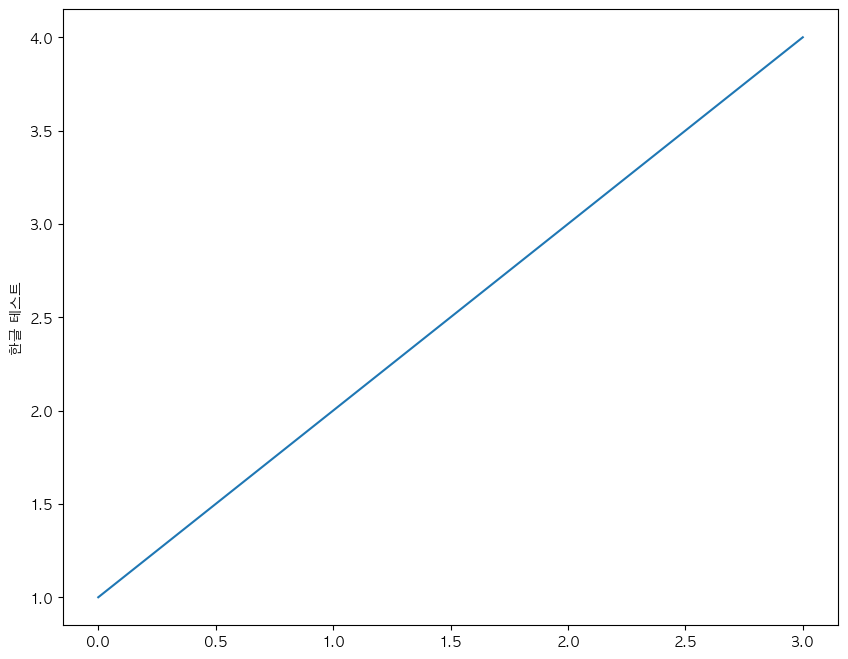

In [11]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

### 이벤트 아티스트 성별,연령대 분포에 따른 인사이트
- 22년도 데뷔후 주요 아티스트들의 팬덤 분포(연령대,성별)
- 남자 순위 여자순위.
- 남성 비중, 여성비중 ~ 팬덤 사용자 증감 상관계수

In [45]:
# 남성,여성비중 증감과 팬덤 사용자 증감 상관성 분석 
fandom_user_gndr_query = '''
    select t1.artist_id
         , t2.artist_name_web_list
         , t2.debut_day
         , t1.dt
         , t1.user_cnt 
         , t1.male_user_cnt
         , t1.female_user_cnt
         , cast(t1.female_user_cnt as double)/t1.user_cnt*100 as female_user_ratio
         , t1.age_102030_user_cnt
         , cast(t1.age_102030_user_cnt as double)/t1.user_cnt*100 as age_102030_user_ratio
    from(
        select artist_id             
             , date(date_parse(log_date,'%Y%m%d')) as dt
             , count(distinct A.member_key) as user_cnt
             , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
             , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
             , count(distinct if(AGE_ENT_PRT_CD in (1,23,4,5,6),A.member_key)) as age_102030_user_cnt
        from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY  A
        left join(
            select MEMBER_KEY
                 , MEMBER_GNDR
                 , AGE_ENT_PRT_CD
            from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
            where log_date = '20250511'
            GROUP BY 1,2,3
        ) B on A.member_key = B.member_key
        where log_date between '20240101' and '20250511'
        and (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
        and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
        and B.member_key is not null
        group by 1,2
    ) t1    
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
    order by 1,4
'''

cur.execute(fandom_user_gndr_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_user_gndr = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_user_gndr.head()

,artist_id,artist_name_web_list,debut_day,dt,user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_102030_user_cnt,age_102030_user_ratio
0,2399724,YENA (최예나),20220117,2024-01-01,2894,1606,1288,44.505874,1101,38.044229
1,2399724,YENA (최예나),20220117,2024-01-02,2893,1606,1287,44.486692,1101,38.057380
2,2399724,YENA (최예나),20220117,2024-01-03,2894,1607,1287,44.471320,1101,38.044229
3,2399724,YENA (최예나),20220117,2024-01-04,2893,1607,1286,44.452126,1101,38.057380
4,2399724,YENA (최예나),20220117,2024-01-05,2893,1607,1286,44.452126,1101,38.057380


    artist_name_web_list  male_corr  female_corr
0            BOYNEXTDOOR   0.934122     0.999043
1            FIFTY FIFTY   0.988347     0.981014
2           H1-KEY (하이키)   0.986073     0.989127
3     LE SSERAFIM (르세라핌)   0.990987     0.994317
4                  NMIXX   0.984084     0.973457
5               NewJeans   0.964663     0.994484
6                  PLAVE   0.948884     0.999501
7                   QWER   0.982112     0.860525
8                  RIIZE   0.936901     0.999255
9             YENA (최예나)   0.999135     0.998519
10  ZEROBASEONE (제로베이스원)   0.808898     0.953284
11                아이리 칸나   0.987252     0.795778
12            아일릿(ILLIT)   0.983038     0.996509
13                   황영웅   0.828244     0.997023


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_50584/86026136.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = correlation_data.groupby('artist_name_web_list').apply(


<Figure size 1200x800 with 0 Axes>

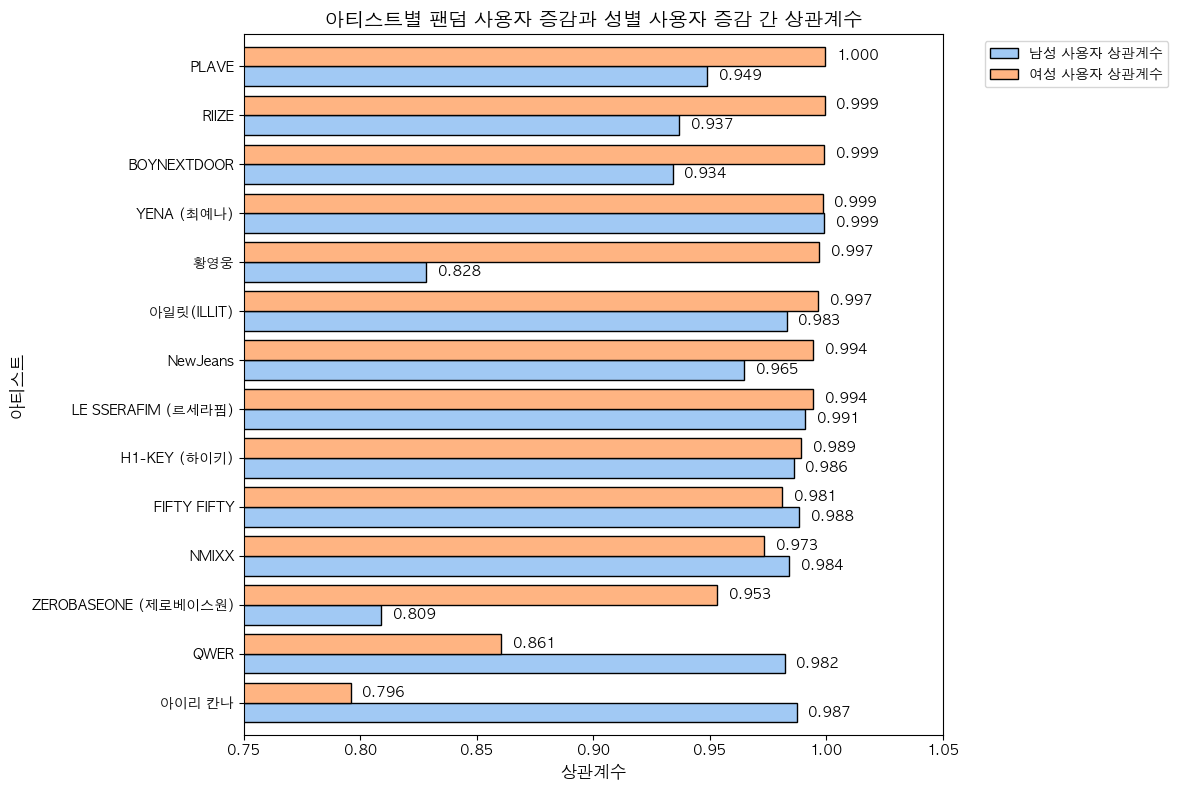

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 (fandom_user_gndr 데이터프레임이 이미 준비되어 있다고 가정)
# fandom_user_gndr = pd.DataFrame(...) 

# 남성 사용자 증감과 여성 사용자 증감을 계산
fandom_user_gndr['male_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['male_user_cnt'].diff()
fandom_user_gndr['female_user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['female_user_cnt'].diff()
fandom_user_gndr['user_diff'] = fandom_user_gndr.groupby('artist_name_web_list')['user_cnt'].diff()

# 상관성 분석을 위한 데이터 필터링 (NaN 제거)
correlation_data = fandom_user_gndr.dropna(subset=['male_user_diff', 'female_user_diff', 'user_diff'])

# 아티스트별 상관계수 계산
correlation_results = correlation_data.groupby('artist_name_web_list').apply(
    lambda group: pd.Series({
        'male_corr': group['user_diff'].corr(group['male_user_diff']),
        'female_corr': group['user_diff'].corr(group['female_user_diff'])
    })
).reset_index()

# 결과 출력
print(correlation_results)

# 여성 사용자 상관계수 기준으로 내림차순 정렬
correlation_results_sorted = correlation_results.sort_values(by='female_corr', ascending=True)

# 시각화: 아티스트별 상관계수 비교 (수평 막대 그래프)
plt.figure(figsize=(12, 8))
ax = correlation_results_sorted.set_index('artist_name_web_list')[['male_corr', 'female_corr']].plot(
    kind='barh', figsize=(12, 8), color=sns.color_palette("pastel", 2), edgecolor='black', width=0.8
)

plt.title('아티스트별 팬덤 사용자 증감과 성별 사용자 증감 간 상관계수', fontsize=14)
plt.xlabel('상관계수', fontsize=12)
plt.ylabel('아티스트', fontsize=12)

# x축 범위를 0.75~1.0으로 설정
plt.xlim(0.75, 1.05)

# 각 막대 끝에 상관계수 값 추가
for bars, corr_label in zip(ax.containers, ['male_corr', 'female_corr']):
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.005,  # 막대 끝에서 약간 오른쪽으로 위치
            bar.get_y() + bar.get_height() / 2,  # 막대의 중앙에 위치
            f'{width:.3f}',  # 소수점 두 자리까지 표시
            ha='left', va='center', fontsize=10, color='black'
        )

# 범례를 그래프 바깥으로 이동
plt.legend(['남성 사용자 상관계수', '여성 사용자 상관계수'], fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

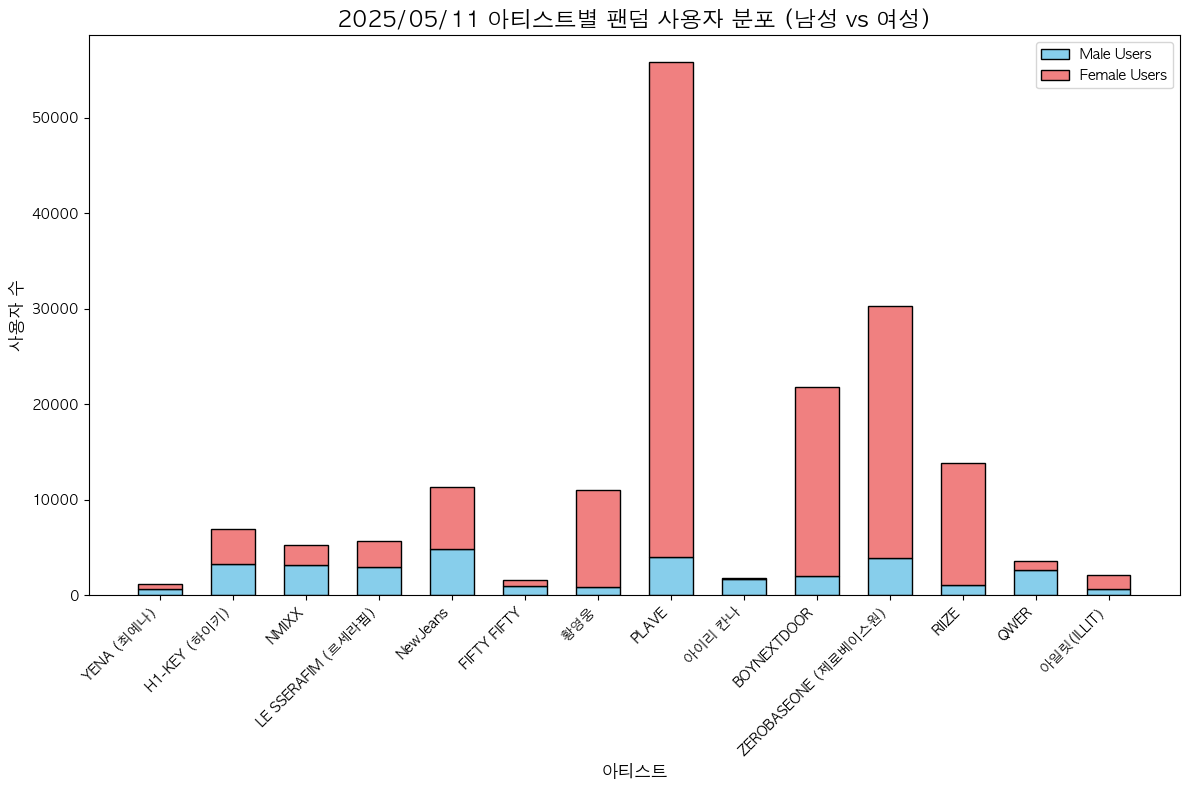

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 스택형 바 플롯 생성
plt.figure(figsize=(12, 8))
bar_width = 0.6

# 남성 사용자와 여성 사용자 데이터
male_users = filtered_data['male_user_cnt']
female_users = filtered_data['female_user_cnt']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯
plt.bar(artists, male_users, label='Male Users', color='skyblue', edgecolor='black', width=bar_width)
plt.bar(artists, female_users, bottom=male_users, label='Female Users', color='lightcoral', edgecolor='black', width=bar_width)

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 분포 (남성 vs 여성)', fontsize=16)
plt.xlabel('아티스트', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()

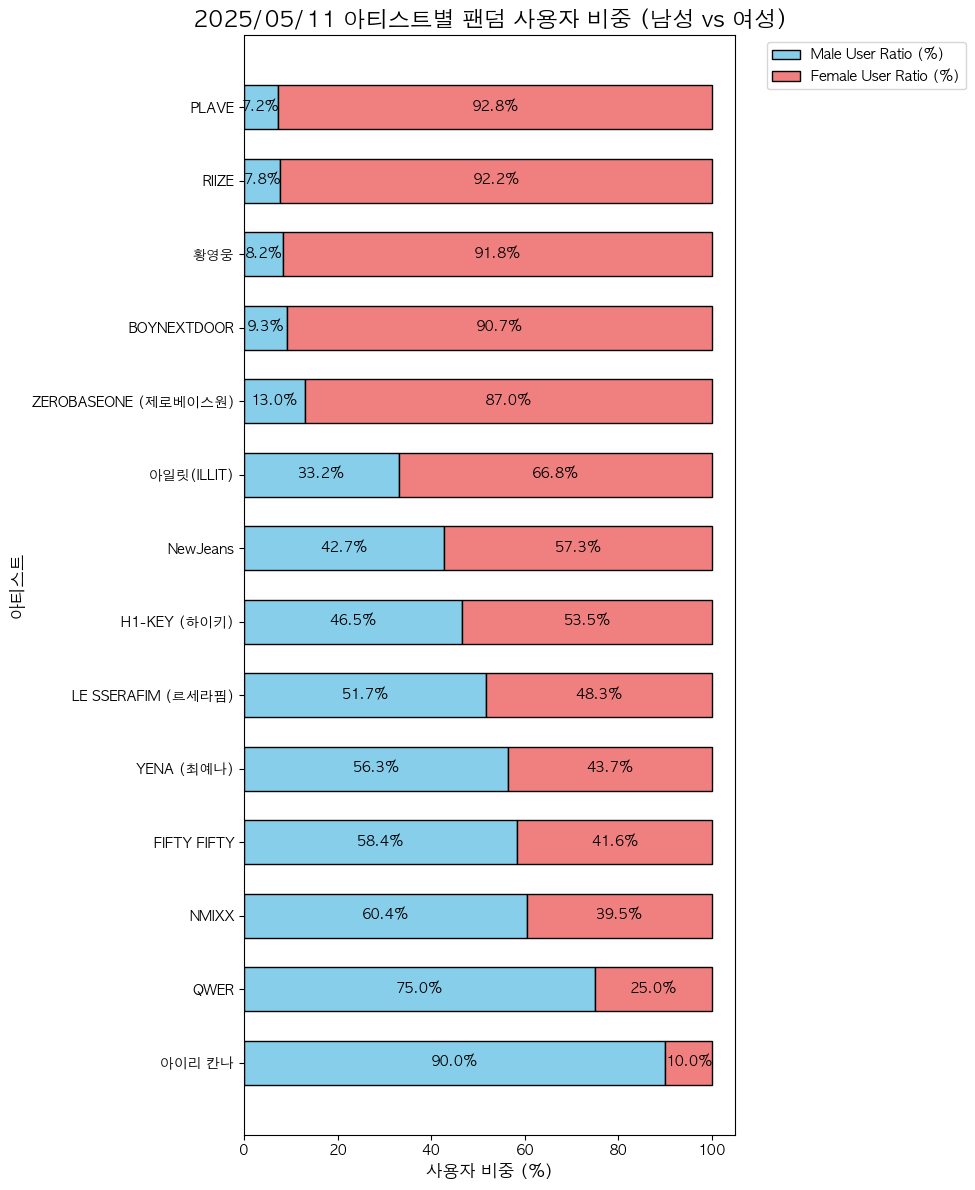

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인 및 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
#filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# 여성 사용자 상관계수 기준으로 내림차순 정렬
filtered_data = filtered_data.sort_values(by='female_user_ratio', ascending=True)

# 스택형 바 플롯 생성 (x축과 y축 전환)
plt.figure(figsize=(10, 12))
bar_width = 0.6

# 남성 사용자 비중과 여성 사용자 비중 데이터
male_ratios = filtered_data['male_user_ratio']
female_ratios = filtered_data['female_user_ratio']
artists = filtered_data['artist_name_web_list']

# 스택형 바 플롯 (x축과 y축 전환)
plt.barh(artists, male_ratios, label='Male User Ratio (%)', color='skyblue', edgecolor='black', height=bar_width)
plt.barh(artists, female_ratios, left=male_ratios, label='Female User Ratio (%)', color='lightcoral', edgecolor='black', height=bar_width)

# 영역별 비율 표시
for i, (male, female) in enumerate(zip(male_ratios, female_ratios)):
    plt.text(male / 2, i, f'{male:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 남성 비율
    plt.text(male + female / 2, i, f'{female:.1f}%', ha='center', va='center', fontsize=10, color='black')  # 여성 비율

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (남성 vs 여성)', fontsize=16)
plt.xlabel('사용자 비중 (%)', fontsize=12)
plt.ylabel('아티스트', fontsize=12)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))  # 레전드를 그래프 바깥으로 이동
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


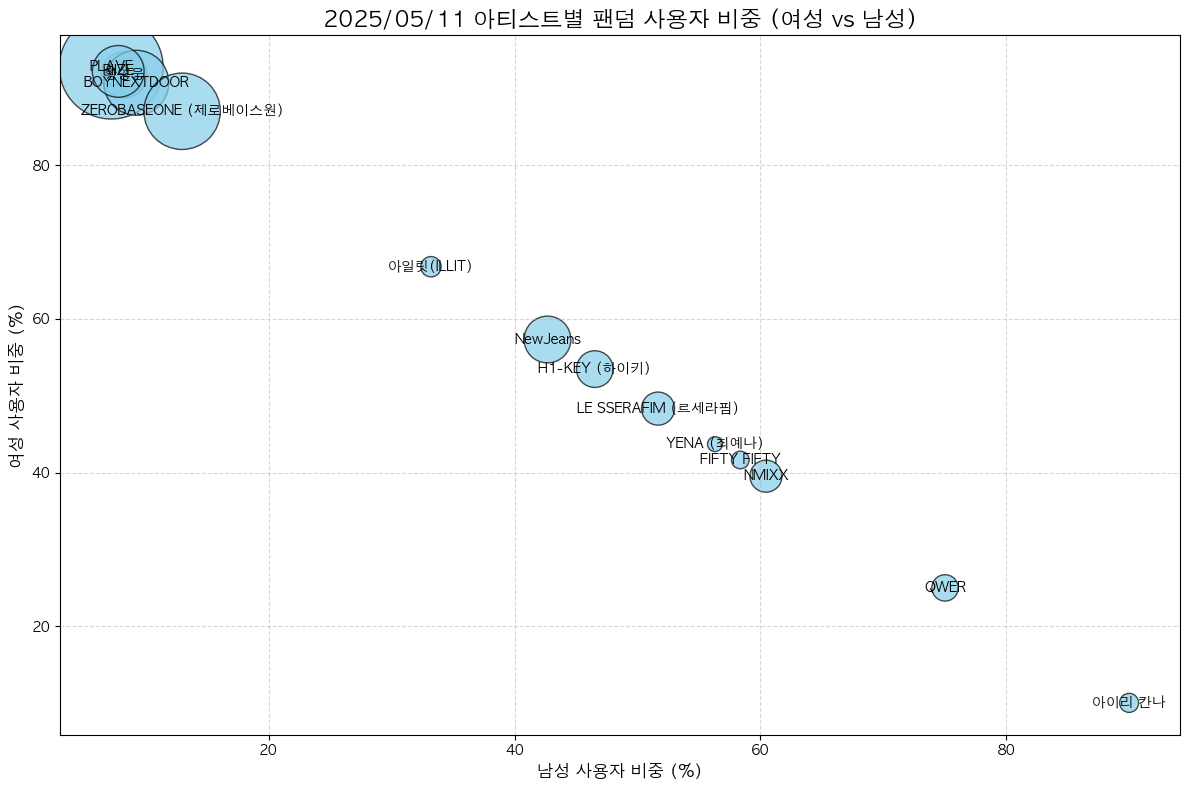

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()

# 여성 사용자 비중과 남성 사용자 비중 계산
filtered_data['female_user_ratio'] = (filtered_data['female_user_cnt'] / filtered_data['user_cnt']) * 100
filtered_data['male_user_ratio'] = (filtered_data['male_user_cnt'] / filtered_data['user_cnt']) * 100

# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['male_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['male_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 남성)', fontsize=16)
plt.xlabel('남성 사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

datetime64[ns]


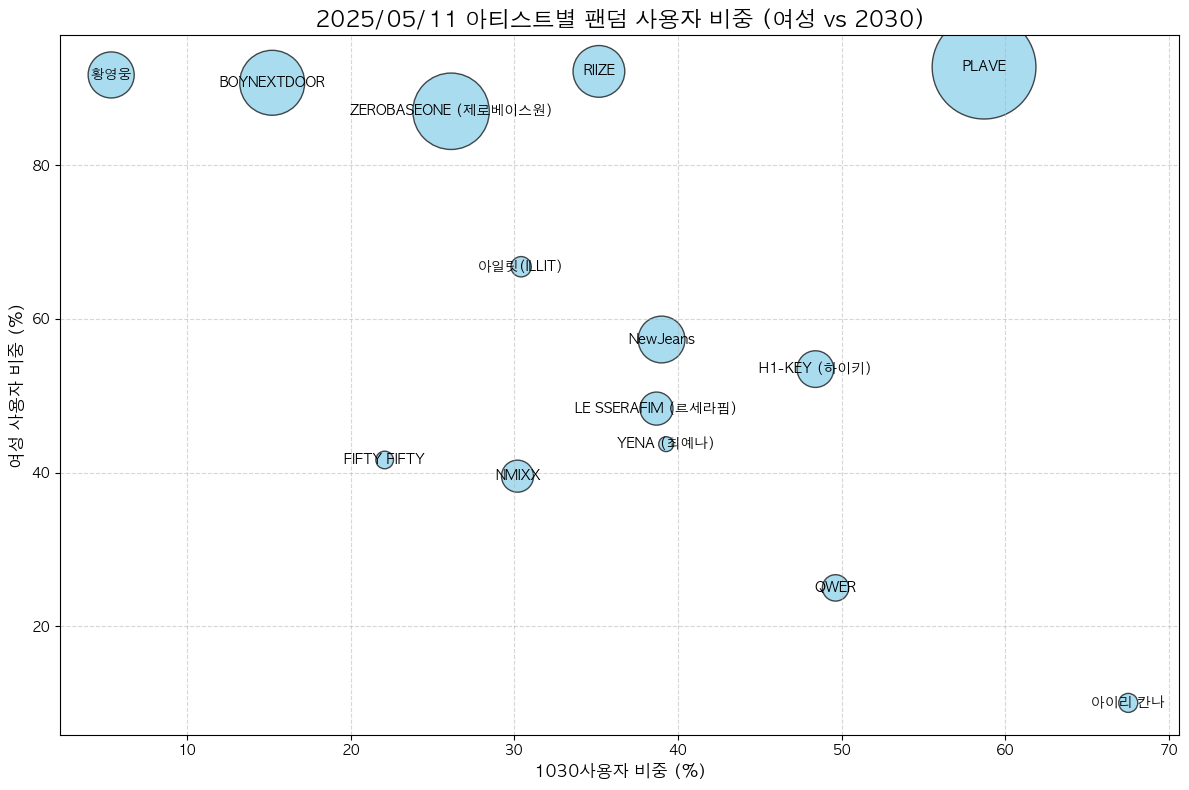

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 'dt' 컬럼의 데이터 타입 확인
print(fandom_user_gndr['dt'].dtype)

# 'dt' 컬럼이 문자열이라면 datetime으로 변환
if fandom_user_gndr['dt'].dtype == 'object':
    fandom_user_gndr['dt'] = pd.to_datetime(fandom_user_gndr['dt'], errors='coerce')

# 2025/05/11 데이터 필터링
latest_date = '2025-05-11'
filtered_data = fandom_user_gndr[fandom_user_gndr['dt'] == latest_date].copy()


# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    filtered_data['age_102030_user_ratio'], 
    filtered_data['female_user_ratio'],     
    s=filtered_data['user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in filtered_data.iterrows():
    plt.text(
        row['age_102030_user_ratio'], 
        row['female_user_ratio'],         
        row['artist_name_web_list'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('2025/05/11 아티스트별 팬덤 사용자 비중 (여성 vs 2030)', fontsize=16)
plt.xlabel('1030사용자 비중 (%)', fontsize=12)
plt.ylabel('여성 사용자 비중 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

### 스트리밍건수에 따른 팬덤 아티스트 분류
- 신규 유입 스트리밍 사용자가 높은 아티스트는?
- 신규유입 스트리밍 사용자 최근 30일이내 해당 아티스트 스트리밍 & 최근 180일이내 스트리밍 이력이 없는 사용자
- 이벤트 참여도를 위한 간접적인 지표를 위하여 앨범 발매 전후로 스트리밍량 증감(앨범 발매 후 7일간 스트리밍 / 직전 7일 스트리밍건수)
- 발매 일주일 후 스트리밍 감소: 단발성 사용자 비중

In [5]:
# 앨범 발매 전후로 스트리밍 사용량 증감 확인 >  if 스트리밍 사용자 및 사용량 증감이 크다면 이벤트 참여도도 증가할 것
fandom_artist_st_incre_query = '''
with artist_df as(    
     select artist_id
         , artist_name
         , fandom_user_cnt
         , male_user_cnt
         , female_user_cnt
         , female_user_ratio
         , age_2030_user_cnt
         , age_2030_user_ratio
         , album_id
         , album_name_web_list as album_name
         , issue_date
         , date(date_parse(issue_date,'%Y%m%d')) as peak_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '6' day) as peak_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '7' day) as pre_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '1' day) as pre_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '7' day) as drop_off_st_strt_date 
         , date(date_parse(issue_date,'%Y%m%d') + interval '14' day) as drop_off_st_end_date 
    from(     
    select B.artist_id
         , C.artist_name_web_list as artist_name
         , A.album_id
         , A.album_name_web_list
         , A.issue_date
         , B.fandom_user_cnt
         , B.male_user_cnt
         , B.female_user_cnt
         , B.female_user_ratio
         , B.age_2030_user_cnt
         , B.age_2030_user_ratio
         , rank() over(partition by A.rep_artist_id_basket order by A.issue_date desc) as rnk
    from hadoop_kent.melon_ods_meta_production.pb_album_dtl_tb_ro A
    join (
        select t1.artist_id
             , t1.fandom_user_cnt
             , t1.male_user_cnt
             , t1.female_user_cnt
             , cast(t1.female_user_cnt as double)/t1.fandom_user_cnt*100 as female_user_ratio
             , t1.age_2030_user_cnt
             , cast(t1.age_2030_user_cnt as double)/t1.fandom_user_cnt*100 as age_2030_user_ratio
        from(
            select artist_id
                 , count(distinct A.member_key) as fandom_user_cnt
                 , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
                 , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (3,4,5,6),A.member_key)) as age_2030_user_cnt
            from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY A
            left join(
                select MEMBER_KEY
                     , MEMBER_GNDR
                     , AGE_ENT_PRT_CD
                from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
                where log_date = '20250511'
                GROUP BY 1,2,3
            ) B on A.member_key = B.member_key
            where log_date = '20250511'
            AND (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
            group by 1
            having(count(distinct A.member_key) > 1000)
        ) t1    
        left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
        where (substr(t2.debut_day,1,4) > '2021' or t1.artist_id in (3478478,3466604))
    ) B on A.rep_artist_id_basket = cast(B.artist_id as varchar)
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro C on A.rep_artist_id_basket = cast(C.artist_id as varchar)
    where substr(issue_date,1,8) < '20250501'
    and A.rep_artist_id_basket in ('3207401','3466604','3458776','3478478','3114174','3180539','3064111','3092950','3070786','3610529','3743525','3457231','3156910','2399724')
    and A.album_type_cd in ('AE0006','AE0007', 'AE0009') /* 미니,정규앨범 기준 */
    --and A.album_type_cd in ('AE0004','AE0007','AE0006','AE0009','AE0010','AE0012') /* 라이브,싱글,EP,정규,OST,베스트 앨범유형 기준 */
    )
    where rnk = 1
    order by 3 desc
), date_df as(
    select melon_short_date_format(dt) as log_date
    from hadoop_kent.melon_ma_stat_production.d_base_dt A
    join artist_df B on A.dt between B.pre_st_strt_date and B.drop_off_st_end_date
    group by 1
)

select f1.artist_id
     , f1.artist_name
     , f1.fandom_user_cnt
     , f1.male_user_cnt
     , f1.female_user_cnt
     , f1.female_user_ratio
     , f1.age_2030_user_cnt
     , f1.age_2030_user_ratio
     , f1.album_name
     , f1.issue_date
     , f1.pre_st_cnt
     , f2.peak_st_cnt
     , f3.drop_off_st_cnt     
     , cast(f2.peak_st_cnt as double)/cast(f1.pre_st_cnt as double) as peak_st_incre
     , cast(f2.peak_st_cnt - f1.pre_st_cnt as double)/cast(f1.pre_st_cnt as double)*100 as peak_st_incre_ratio
     , cast(f3.drop_off_st_cnt as double)/cast(f2.peak_st_cnt as double) as drop_off_st_incre
     , cast(f3.drop_off_st_cnt - f2.peak_st_cnt as double)/cast(f2.peak_st_cnt as double)*100 as drop_off_st_incre_ratio
     , f1.pre_st_lv
     , f2.peak_st_lv
     , f3.drop_off_st_lv
     , cast(f2.peak_st_lv as double)/cast(f1.pre_st_lv as double) as peak_st_lv_incre
     , cast(f2.peak_st_lv - f1.pre_st_lv as double)/cast(f1.pre_st_lv as double)*100 as peak_st_lv_incre_ratio
     , cast(f3.drop_off_st_lv as double)/cast(f2.peak_st_lv as double) as drop_off_st_lv_incre
     , cast(f3.drop_off_st_lv - f2.peak_st_lv as double)/cast(f2.peak_st_lv as double)*100 as drop_off_st_lv_incre_ratio
from(
    select t2.artist_id
         , t2.artist_name
         , t2.album_name
         , t2.issue_date
         , t2.fandom_user_cnt
         , t2.male_user_cnt
         , t2.female_user_cnt
         , t2.female_user_ratio
         , t2.age_2030_user_cnt
         , t2.age_2030_user_ratio
         , sum(st_cnt) as pre_st_cnt
         , count(distinct t1.member_key) as pre_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240612' and '20250515' 
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.pre_st_strt_date and t2.pre_st_end_date
    group by 1,2,3,4,5,6,7,8,9,10
) f1
left join(
    select t2.artist_id
         , sum(st_cnt) as peak_st_cnt
         , count(distinct t1.member_key) as peak_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240612' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.peak_st_strt_date and t2.peak_st_end_date
    group by 1
) f2 on f1.artist_id = f2.artist_id
left join(
    select t2.artist_id
         , sum(st_cnt) as drop_off_st_cnt
         , count(distinct t1.member_key) as drop_off_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240612' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (3207401,3466604,3458776,3478478,3114174,3180539,3064111,3092950,3070786,3610529,3743525,3457231,3156910,2399724)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.drop_off_st_strt_date and t2.drop_off_st_end_date
    group by 1
) f3 on f1.artist_id = f3.artist_id
'''

cur.execute(fandom_artist_st_incre_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_artist_st_incre = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_artist_st_incre

,artist_id,artist_name,fandom_user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_2030_user_cnt,age_2030_user_ratio,album_name,issue_date,...,peak_st_incre_ratio,drop_off_st_incre,drop_off_st_incre_ratio,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,peak_st_lv_incre_ratio,drop_off_st_lv_incre,drop_off_st_lv_incre_ratio
0,3070786,NMIXX,5588,3220,2106,37.687903,2560,45.812455,Fe3O4: FORWARD,20250317,...,80.033820,0.921125,-7.887529,237313,292313,294323,1.231761,23.176143,1.006876,0.687619
1,3207401,PLAVE,58094,4027,51820,89.200262,42191,72.625400,Caligo Pt.1,20250203,...,93.092823,0.952196,-4.780418,431447,586782,613783,1.360033,36.003263,1.046015,4.601539
2,3064111,H1-KEY (하이키),7002,3246,3730,53.270494,4743,67.737789,H1-KEY 3rd Mini Album [LOVE or HATE],20240619,...,75.818527,0.863654,-13.634644,212064,269765,260643,1.272092,27.209239,0.966185,-3.381462
3,3180539,황영웅,11327,909,10111,89.264589,628,5.544275,당신 편,20241015,...,100.631396,0.967834,-3.216619,31107,44916,48423,1.443919,44.391938,1.078079,7.807908
4,3466604,ZEROBASEONE (제로베이스원),31471,3929,26357,83.750119,13129,41.717772,Only One Story (Korean ver.),20250415,...,12.693900,1.067497,6.749728,125129,129820,133064,1.037489,3.748931,1.024988,2.498845
5,2399724,YENA (최예나),1209,648,503,41.604632,695,57.485525,네모네모,20240930,...,114.444970,1.372972,37.297185,115770,175781,217686,1.518364,51.836400,1.238393,23.839323
6,3457231,아이리 칸나,1983,1687,188,9.480585,1599,80.635401,最終花 (The Last Flower),20240821,...,10.534019,1.034961,3.496092,15738,16177,16119,1.027894,2.789427,0.996415,-0.358534
7,3092950,LE SSERAFIM (르세라핌),6157,2935,2745,44.583401,3160,51.323697,Come Over (Remixes),20250331,...,5.374843,1.194878,19.487779,617816,670052,753953,1.084549,8.454945,1.125216,12.521565
8,3478478,RIIZE,14649,1080,12801,87.384804,7235,49.389037,Hug (포옹),20250108,...,48.385232,1.095793,9.579253,455392,543229,578575,1.192882,19.288218,1.065066,6.506648
9,3743525,아일릿(ILLIT),2254,711,1430,63.442768,1165,51.685892,Almond Chocolate (Korean Ver.),20250310,...,9.610952,1.153753,15.375293,431454,456158,487974,1.057258,5.725755,1.069748,6.974776


In [6]:
fandom_artist_st_incre

,artist_id,artist_name,fandom_user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_2030_user_cnt,age_2030_user_ratio,album_name,issue_date,...,peak_st_incre_ratio,drop_off_st_incre,drop_off_st_incre_ratio,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,peak_st_lv_incre_ratio,drop_off_st_lv_incre,drop_off_st_lv_incre_ratio
0,3070786,NMIXX,5588,3220,2106,37.687903,2560,45.812455,Fe3O4: FORWARD,20250317,...,80.033820,0.921125,-7.887529,237313,292313,294323,1.231761,23.176143,1.006876,0.687619
1,3207401,PLAVE,58094,4027,51820,89.200262,42191,72.625400,Caligo Pt.1,20250203,...,93.092823,0.952196,-4.780418,431447,586782,613783,1.360033,36.003263,1.046015,4.601539
2,3064111,H1-KEY (하이키),7002,3246,3730,53.270494,4743,67.737789,H1-KEY 3rd Mini Album [LOVE or HATE],20240619,...,75.818527,0.863654,-13.634644,212064,269765,260643,1.272092,27.209239,0.966185,-3.381462
3,3180539,황영웅,11327,909,10111,89.264589,628,5.544275,당신 편,20241015,...,100.631396,0.967834,-3.216619,31107,44916,48423,1.443919,44.391938,1.078079,7.807908
4,3466604,ZEROBASEONE (제로베이스원),31471,3929,26357,83.750119,13129,41.717772,Only One Story (Korean ver.),20250415,...,12.693900,1.067497,6.749728,125129,129820,133064,1.037489,3.748931,1.024988,2.498845
5,2399724,YENA (최예나),1209,648,503,41.604632,695,57.485525,네모네모,20240930,...,114.444970,1.372972,37.297185,115770,175781,217686,1.518364,51.836400,1.238393,23.839323
6,3457231,아이리 칸나,1983,1687,188,9.480585,1599,80.635401,最終花 (The Last Flower),20240821,...,10.534019,1.034961,3.496092,15738,16177,16119,1.027894,2.789427,0.996415,-0.358534
7,3092950,LE SSERAFIM (르세라핌),6157,2935,2745,44.583401,3160,51.323697,Come Over (Remixes),20250331,...,5.374843,1.194878,19.487779,617816,670052,753953,1.084549,8.454945,1.125216,12.521565
8,3478478,RIIZE,14649,1080,12801,87.384804,7235,49.389037,Hug (포옹),20250108,...,48.385232,1.095793,9.579253,455392,543229,578575,1.192882,19.288218,1.065066,6.506648
9,3743525,아일릿(ILLIT),2254,711,1430,63.442768,1165,51.685892,Almond Chocolate (Korean Ver.),20250310,...,9.610952,1.153753,15.375293,431454,456158,487974,1.057258,5.725755,1.069748,6.974776


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_33440/105780619.py:32: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


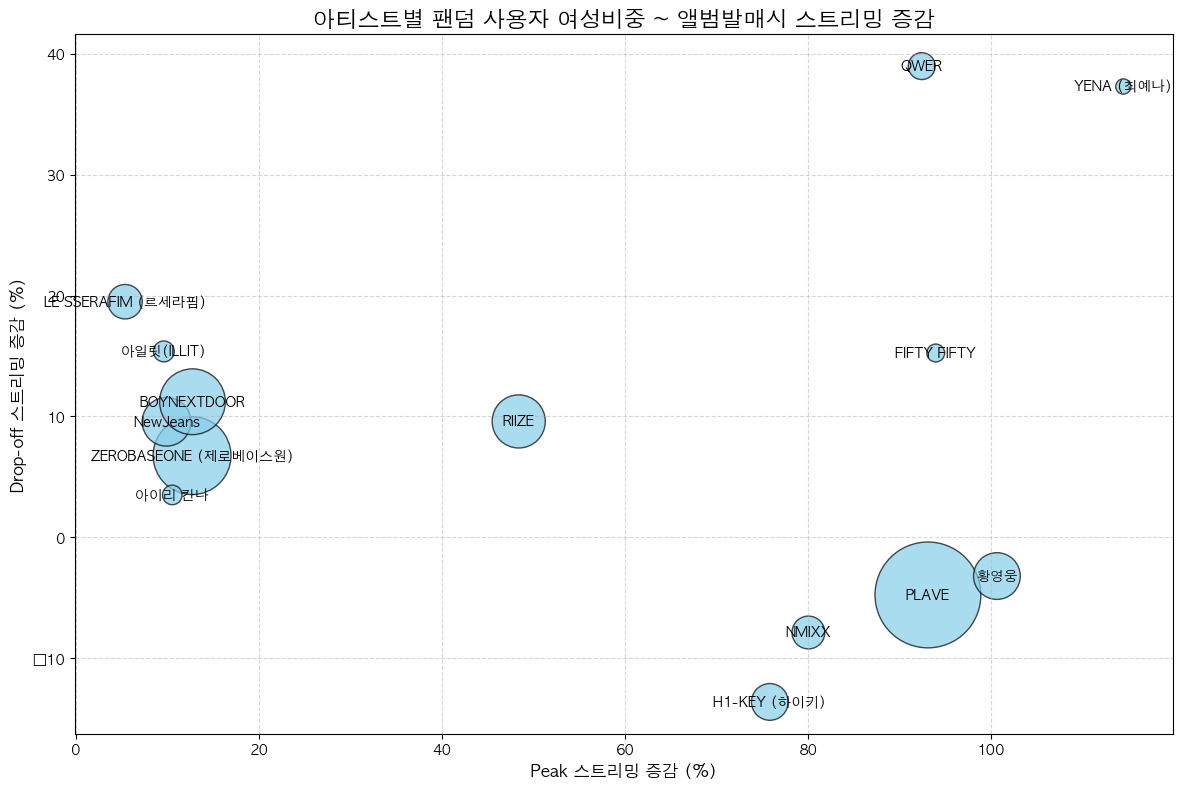

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


# Scatter plot 생성
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    fandom_artist_st_incre['peak_st_incre_ratio'], 
    fandom_artist_st_incre['drop_off_st_incre_ratio'],     
    s=fandom_artist_st_incre['fandom_user_cnt'] / 10,  # 팬덤 사용자 수에 비례한 점 크기
    alpha=0.7, 
    c='skyblue', 
    edgecolor='black'
)

# 각 점에 아티스트 이름 추가
for i, row in fandom_artist_st_incre.iterrows():
    plt.text(
        row['peak_st_incre_ratio'], 
        row['drop_off_st_incre_ratio'],         
        row['artist_name'], 
        fontsize=10, 
        ha='center', 
        va='center'
    )

# 그래프 꾸미기
plt.title('아티스트별 팬덤 사용자 여성비중 ~ 앨범발매시 스트리밍 증감', fontsize=16)
plt.xlabel('Peak 스트리밍 증감 (%)', fontsize=12)
plt.ylabel('Drop-off 스트리밍 증감 (%)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# 그래프 출력
plt.show()

### 20년도 이후 아티스트(팬덤 사용자 500명 이상) 32명 기준으로 k-means 군집화
- 4세대 아이돌 포함하여 다시 집계
- 20년도 이후 데뷔 아티스트 중 핸덤 사용자 500명 이상 아티스트 32명 기준

In [97]:
# 앨범 발매 전후로 스트리밍 사용량 증감 확인 >  if 스트리밍 사용자 및 사용량 증감이 크다면 이벤트 참여도도 증가할 것
fandom_artist_cluster_query = '''
with artist_df as(    
     select artist_id
         , artist_name
         , debut_day
         , 2025 - cast(substr(debut_day,1,4) as bigint) + 1 as debut_term
         , fandom_user_cnt
         , male_user_cnt
         , female_user_cnt
         , female_user_ratio
         , age_2030_user_cnt
         , age_2030_user_ratio
         , age_10_user_cnt
         , age_10_user_ratio
         , album_id
         , album_name_web_list as album_name
         , issue_date
         , date(date_parse(issue_date,'%Y%m%d')) as peak_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '6' day) as peak_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '7' day) as pre_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '1' day) as pre_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '7' day) as drop_off_st_strt_date 
         , date(date_parse(issue_date,'%Y%m%d') + interval '14' day) as drop_off_st_end_date 
    from(     
    select B.artist_id
         , C.artist_name_web_list as artist_name
         , case
            when B.artist_id = 3478478 then '20230904'
            when B.artist_id = 3466604 then '20230710'
            else debut_day
           end as debut_day     
         , A.album_id
         , A.album_name_web_list
         , A.issue_date
         , B.fandom_user_cnt
         , B.male_user_cnt
         , B.female_user_cnt
         , B.female_user_ratio
         , B.age_2030_user_cnt
         , B.age_2030_user_ratio
         , B.age_10_user_cnt
         , B.age_10_user_ratio
         , rank() over(partition by A.rep_artist_id_basket order by A.issue_date desc,A.album_id) as rnk
    from hadoop_kent.melon_ods_meta_production.pb_album_dtl_tb_ro A
    join (
        select t1.artist_id
             , t1.fandom_user_cnt
             , t1.male_user_cnt
             , t1.female_user_cnt
             , cast(t1.female_user_cnt as double)/t1.fandom_user_cnt*100 as female_user_ratio
             , t1.age_2030_user_cnt
             , cast(t1.age_2030_user_cnt as double)/t1.fandom_user_cnt*100 as age_2030_user_ratio
             , t1.age_10_user_cnt
             , cast(t1.age_10_user_cnt as double)/t1.fandom_user_cnt*100 as age_10_user_ratio
        from(
            select artist_id
                 , count(distinct A.member_key) as fandom_user_cnt
                 , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
                 , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (3,4,5,6),A.member_key)) as age_2030_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (1,2),A.member_key)) as age_10_user_cnt
            from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY A
            left join(
                select MEMBER_KEY
                     , MEMBER_GNDR
                     , AGE_ENT_PRT_CD
                from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
                where log_date = '20250511'
                GROUP BY 1,2,3
            ) B on A.member_key = B.member_key
            where log_date = '20250511'
            and (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
            and artist_id not in (2727,720223,1384479,2881410,3058057,3101552,1813896,107632,2939206,1703695) /* various artist,동요(뽀로로,주니토니,핑크퐁,쥬니버,캐치니티핑),단기성 프로젝트 그룹(WSG워너비,MSG워너비),종교음악(WELOVE,어노인팅) 제외 */
            group by 1
            having(count(distinct A.member_key) > 1000)
        ) t1    
        left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
        where (substr(t2.debut_day,1,4) > '2019' or t1.artist_id in (3478478,3466604,261143,861436,2632253,994944,6984))
    ) B on A.rep_artist_id_basket = cast(B.artist_id as varchar)
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro C on A.rep_artist_id_basket = cast(C.artist_id as varchar)
    where substr(issue_date,1,8) between '20240101' and '20250501'
    and A.album_type_cd in ('AE0006','AE0007', 'AE0009') /* 싱글,미니,정규앨범 기준 */
    --and A.album_type_cd in ('AE0004','AE0007','AE0006','AE0009','AE0010','AE0012') /* 라이브,싱글,EP,정규,OST,베스트 앨범유형 기준 */
    )
    where rnk = 1
), date_df as(
    select melon_short_date_format(dt) as log_date
    from hadoop_kent.melon_ma_stat_production.d_base_dt A
    join artist_df B on A.dt between B.pre_st_strt_date and B.drop_off_st_end_date
    group by 1
)

select f1.artist_id
     , f1.artist_name
     , f1.fandom_user_cnt
     , f1.male_user_cnt
     , f1.female_user_cnt
     , f1.female_user_ratio
     , f1.age_2030_user_cnt
     , f1.age_2030_user_ratio
     , f1.age_10_user_cnt
     , f1.age_10_user_ratio
     , f1.album_name
     , f1.issue_date
     , f1.pre_st_cnt
     , f2.peak_st_cnt
     , f3.drop_off_st_cnt     
     , cast(f2.peak_st_cnt as double)/cast(f1.pre_st_cnt as double) as peak_st_incre
     , cast(f2.peak_st_cnt - f1.pre_st_cnt as double)/cast(f1.pre_st_cnt as double)*100 as peak_st_incre_ratio
     , cast(f3.drop_off_st_cnt as double)/cast(f2.peak_st_cnt as double) as drop_off_st_incre
     , cast(f3.drop_off_st_cnt - f2.peak_st_cnt as double)/cast(f2.peak_st_cnt as double)*100 as drop_off_st_incre_ratio
     , f1.pre_st_lv
     , f2.peak_st_lv
     , f3.drop_off_st_lv
     , cast(f2.peak_st_lv as double)/cast(f1.pre_st_lv as double) as peak_st_lv_incre
     , cast(f2.peak_st_lv - f1.pre_st_lv as double)/cast(f1.pre_st_lv as double)*100 as peak_st_lv_incre_ratio
     , cast(f3.drop_off_st_lv as double)/cast(f2.peak_st_lv as double) as drop_off_st_lv_incre
     , cast(f3.drop_off_st_lv - f2.peak_st_lv as double)/cast(f2.peak_st_lv as double)*100 as drop_off_st_lv_incre_ratio
from(
    select t2.artist_id
         , t2.artist_name
         , t2.album_name
         , t2.issue_date
         , t2.fandom_user_cnt
         , t2.male_user_cnt
         , t2.female_user_cnt
         , t2.female_user_ratio
         , t2.age_2030_user_cnt
         , t2.age_2030_user_ratio
         , t2.age_10_user_cnt
         , t2.age_10_user_ratio
         , sum(st_cnt) as pre_st_cnt
         , count(distinct t1.member_key) as pre_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240213' and '20250515' 
    and log_date in (select log_date from date_df)
    and artist_id in (261143,994944,6984,861436,2632253,3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.pre_st_strt_date and t2.pre_st_end_date
    group by 1,2,3,4,5,6,7,8,9,10,11,12
) f1
left join(
    select t2.artist_id
         , sum(st_cnt) as peak_st_cnt
         , count(distinct t1.member_key) as peak_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240213' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (261143,994944,6984,861436,2632253,3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.peak_st_strt_date and t2.peak_st_end_date
    group by 1
) f2 on f1.artist_id = f2.artist_id
left join(
    select t2.artist_id
         , sum(st_cnt) as drop_off_st_cnt
         , count(distinct t1.member_key) as drop_off_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20240213' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (261143,994944,6984,861436,2632253,3207401,3466604,3055146,3458776,3478478,2899555,3114174,3180539,2763924,2863902,3064111,3092950,672853,2736779,3070786,2899079,3610529,2138620,2763943,2899290,2880278,3743525,2645970,3457231,3156910,2399724,780918,3192307,2758756,672855,3089953,2190430)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.drop_off_st_strt_date and t2.drop_off_st_end_date
    group by 1
) f3 on f1.artist_id = f3.artist_id
'''

cur.execute(fandom_artist_cluster_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_artist_cluster_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_artist_cluster_df

,artist_id,artist_name,fandom_user_cnt,male_user_cnt,female_user_cnt,female_user_ratio,age_2030_user_cnt,age_2030_user_ratio,age_10_user_cnt,age_10_user_ratio,...,peak_st_incre_ratio,drop_off_st_incre,drop_off_st_incre_ratio,pre_st_lv,peak_st_lv,drop_off_st_lv,peak_st_lv_incre,peak_st_lv_incre_ratio,drop_off_st_lv_incre,drop_off_st_lv_incre_ratio
0,6984,G-DRAGON,22114,7289,14362,64.945284,9486,42.895903,3607,16.310934,...,164.641474,1.003043,0.304256,1119780,1496645,1532288,1.336553,33.655272,1.023815,2.381527
1,3466604,ZEROBASEONE (제로베이스원),31471,3929,26357,83.750119,13129,41.717772,9290,29.519240,...,12.693900,1.067497,6.749728,125129,129820,133064,1.037489,3.748931,1.024988,2.498845
2,3156910,FIFTY FIFTY,1656,939,670,40.458937,461,27.838164,70,4.227053,...,93.947495,1.152433,15.243316,163263,216509,237377,1.326136,32.613636,1.096384,9.638398
3,3070786,NMIXX,5588,3220,2106,37.687903,2560,45.812455,1561,27.934860,...,80.033820,0.921125,-7.887529,237313,292313,294323,1.231761,23.176143,1.006876,0.687619
4,3457231,아이리 칸나,1983,1687,188,9.480585,1599,80.635401,132,6.656581,...,10.534019,1.034961,3.496092,15738,16177,16119,1.027894,2.789427,0.996415,-0.358534
5,861436,세븐틴 (SEVENTEEN),51606,10741,39170,75.902027,23751,46.023718,10708,20.749525,...,-4.502089,1.107865,10.786516,552700,525022,543407,0.949922,-5.007780,1.035018,3.501758
6,2736779,LUCY,5611,1163,4190,74.674746,2643,47.103903,1788,31.865978,...,25.589441,0.915026,-8.497430,292324,315950,309080,1.080821,8.082128,0.978256,-2.174395
7,3180539,황영웅,11327,909,10111,89.264589,628,5.544275,10,0.088285,...,100.631396,0.967834,-3.216619,31107,44916,48423,1.443919,44.391938,1.078079,7.807908
8,3743525,아일릿(ILLIT),2254,711,1430,63.442768,1165,51.685892,442,19.609583,...,9.610952,1.153753,15.375293,431454,456158,487974,1.057258,5.725755,1.069748,6.974776
9,2632253,투모로우바이투게더,27896,4374,22160,79.437912,6091,21.834672,10356,37.123602,...,-4.657596,1.096729,9.672913,186932,189266,200692,1.012486,1.248582,1.060370,6.037006


In [ ]:
# 앨범 발매 전후로 스트리밍 사용량 증감 확인 >  if 스트리밍 사용자 및 사용량 증감이 크다면 이벤트 참여도도 증가할 것
# 데뷔년도 구분 없이 24년도 이후 발매앨범이 있는 아티스트 집계(팬덤 사용자 > 1000명 이상)
# 2025/05/11 기준으로 팬덤 사용자 수, 성비, 연령대 비율 확인
fandom_artist_cluster_query = '''
with artist_df as(    
     select artist_id
         , artist_name
         , debut_day
         , 2025 - cast(substr(debut_day,1,4) as bigint) + 1 as debut_term
         , fandom_user_cnt
         , male_user_cnt
         , female_user_cnt
         , female_user_ratio
         , age_2030_user_cnt
         , age_2030_user_ratio
         , album_id
         , album_name_web_list as album_name
         , issue_date
         , date(date_parse(issue_date,'%Y%m%d')) as peak_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '6' day) as peak_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '7' day) as pre_st_strt_date
         , date(date_parse(issue_date,'%Y%m%d') - interval '1' day) as pre_st_end_date
         , date(date_parse(issue_date,'%Y%m%d') + interval '7' day) as drop_off_st_strt_date 
         , date(date_parse(issue_date,'%Y%m%d') + interval '14' day) as drop_off_st_end_date 
    from(     
    select B.artist_id
         , C.artist_name_web_list as artist_name
         , case
            when B.artist_id = 3478478 then '20230904'
            when B.artist_id = 3466604 then '20230710'
            else debut_day
           end as debut_day     
         , A.album_id
         , A.album_name_web_list
         , A.issue_date
         , B.fandom_user_cnt
         , B.male_user_cnt
         , B.female_user_cnt
         , B.female_user_ratio
         , B.age_2030_user_cnt
         , B.age_2030_user_ratio
         , rank() over(partition by A.rep_artist_id_basket order by A.issue_date desc,A.album_id) as rnk
    from hadoop_kent.melon_ods_meta_production.pb_album_dtl_tb_ro A
    join (
        select t1.artist_id
             , t1.fandom_user_cnt
             , t1.male_user_cnt
             , t1.female_user_cnt
             , cast(t1.female_user_cnt as double)/t1.fandom_user_cnt*100 as female_user_ratio
             , t1.age_2030_user_cnt
             , cast(t1.age_2030_user_cnt as double)/t1.fandom_user_cnt*100 as age_2030_user_ratio
        from(
            select artist_id
                 , count(distinct A.member_key) as fandom_user_cnt
                 , count(distinct if(MEMBER_GNDR = 1,A.member_key)) as male_user_cnt
                 , count(distinct if(MEMBER_GNDR = 2,A.member_key)) as female_user_cnt
                 , count(distinct if(AGE_ENT_PRT_CD in (3,4,5,6),A.member_key)) as age_2030_user_cnt
            from HADOOP_KENT.MELON_MA_PROD_PRODUCTION.A_USER_ARTIST_FANDOM_TRGT_DAY A
            left join(
                select MEMBER_KEY
                     , MEMBER_GNDR
                     , AGE_ENT_PRT_CD
                from HADOOP_KENT.MELON_MA_TMK_PRODUCTION.A_USER_PROFILE_DAY
                where log_date = '20250511'
                GROUP BY 1,2,3
            ) B on A.member_key = B.member_key
            where log_date = '20250511'
            and (CONTAINS(FANDOM_TYPE,'A')=true OR CONTAINS(FANDOM_TYPE,'B')=true OR CONTAINS(FANDOM_TYPE,'C')=true)
            and artist_id not in (2727,720223,1384479,2881410,3058057,3101552,1813896,107632,2939206,1703695) /* various artist,동요(뽀로로,주니토니,핑크퐁,쥬니버,캐치니티핑),단기성 프로젝트 그룹(WSG워너비,MSG워너비),종교음악(WELOVE,어노인팅) 제외 */
            group by 1
            having(count(distinct A.member_key) > 1000)
        ) t1    
        left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro t2 on t1.artist_id = t2.artist_id
        where (substr(t2.debut_day,1,4) > '2000' or t1.artist_id in (3478478,3466604))
    ) B on A.rep_artist_id_basket = cast(B.artist_id as varchar)
    left join hadoop_kent.melon_ods_meta_production.pb_artist_dtl_tb_ro C on A.rep_artist_id_basket = cast(C.artist_id as varchar)
    where substr(issue_date,1,8) between '20240101' and '20250501'
    and A.album_type_cd in ('AE0006','AE0007', 'AE0009') /* 싱글,미니,정규앨범 기준 */
    --and A.album_type_cd in ('AE0004','AE0007','AE0006','AE0009','AE0010','AE0012') /* 라이브,싱글,EP,정규,OST,베스트 앨범유형 기준 */
    )
    where rnk = 1
    
), date_df as(
    select melon_short_date_format(dt) as log_date
    from hadoop_kent.melon_ma_stat_production.d_base_dt A
    join artist_df B on A.dt between B.pre_st_strt_date and B.drop_off_st_end_date
    group by 1
)

select f1.artist_id
     , f1.artist_name
     , f1.debut_term
     , f1.fandom_user_cnt
     , f1.male_user_cnt
     , f1.female_user_cnt
     , f1.female_user_ratio
     , f1.age_2030_user_cnt
     , f1.age_2030_user_ratio
     , f1.age_10_user_cnt
     , f1.age_10_user_ratio
     , f1.album_name
     , f1.issue_date
     , f1.pre_st_cnt
     , f2.peak_st_cnt
     , f3.drop_off_st_cnt     
     , cast(f2.peak_st_cnt as double)/cast(f1.pre_st_cnt as double) as peak_st_incre
     , cast(f2.peak_st_cnt - f1.pre_st_cnt as double)/cast(f1.pre_st_cnt as double)*100 as peak_st_incre_ratio
     , cast(f3.drop_off_st_cnt as double)/cast(f2.peak_st_cnt as double) as drop_off_st_incre
     , cast(f3.drop_off_st_cnt - f2.peak_st_cnt as double)/cast(f2.peak_st_cnt as double)*100 as drop_off_st_incre_ratio
     , f1.pre_st_lv
     , f2.peak_st_lv
     , f3.drop_off_st_lv
     , cast(f2.peak_st_lv as double)/cast(f1.pre_st_lv as double) as peak_st_lv_incre
     , cast(f2.peak_st_lv - f1.pre_st_lv as double)/cast(f1.pre_st_lv as double)*100 as peak_st_lv_incre_ratio
     , cast(f3.drop_off_st_lv as double)/cast(f2.peak_st_lv as double) as drop_off_st_lv_incre
     , cast(f3.drop_off_st_lv - f2.peak_st_lv as double)/cast(f2.peak_st_lv as double)*100 as drop_off_st_lv_incre_ratio
from(
    select t2.artist_id
         , t2.artist_name
         , t2.album_name
         , t2.issue_date
         , t2.fandom_user_cnt
         , t2.male_user_cnt
         , t2.female_user_cnt
         , t2.female_user_ratio
         , t2.age_2030_user_cnt
         , t2.age_2030_user_ratio
         , t2.age_10_user_cnt
         , t2.age_10_user_ratio
         , t2.debut_term
         , sum(st_cnt) as pre_st_cnt
         , count(distinct t1.member_key) as pre_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20231228' and '20250515' 
    and log_date in (select log_date from date_df)
    and artist_id in (668811,	742577,	2622030,	2086970,	325867,	2137482,	3156910,	2749421,	2743730,	967229,	2880278,	3458776,	1865635,	672853,	236815,	965986,	1273231,	907416,	2112495,	3610529,	2899555,	2399724,	1183574,	861430,	2754623,	712452,	52607,	991413,	227595,	3092950,	1701869,	838654,	3457231,	614026,	672859,	715573,	2006344,	1865969,	468244,	602193,	231070,	3466604,	894864,	2763943,	251080,	2639484,	1284664,	2632253,	2111354,	720018,	2744750,	585492,	3743525,	28801,	553325,	945663,	753762,	3114174,	1907398,	2736779,	54684,	2863902,	6984,	858125,	2898675,	2899079,	774246,	905701,	673033,	725985,	2138620,	672262,	2398260,	236797,	674710,	2899290,	3064111,	857994,	751611,	3070786,	828478,	2019210,	2298864,	725991,	839732,	752425,	2763924,	723192,	203912,	647971,	476181,	2112233,	3478478,	1816126,	2203907,	861336,	792022,	629371,	203099,	3180539,	2645970,	1624993,	1066419,	566431,	727245,	2620698,	3055146,	443420,	772253,	735506,	861436,	261143,	2636153,	3207401,	2871809,	1993305,	688432,	471741,	780066,	994944,	699632,	725987)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.pre_st_strt_date and t2.pre_st_end_date
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13
) f1
left join(
    select t2.artist_id
         , sum(st_cnt) as peak_st_cnt
         , count(distinct t1.member_key) as peak_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20231228' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (668811,	742577,	2622030,	2086970,	325867,	2137482,	3156910,	2749421,	2743730,	967229,	2880278,	3458776,	1865635,	672853,	236815,	965986,	1273231,	907416,	2112495,	3610529,	2899555,	2399724,	1183574,	861430,	2754623,	712452,	52607,	991413,	227595,	3092950,	1701869,	838654,	3457231,	614026,	672859,	715573,	2006344,	1865969,	468244,	602193,	231070,	3466604,	894864,	2763943,	251080,	2639484,	1284664,	2632253,	2111354,	720018,	2744750,	585492,	3743525,	28801,	553325,	945663,	753762,	3114174,	1907398,	2736779,	54684,	2863902,	6984,	858125,	2898675,	2899079,	774246,	905701,	673033,	725985,	2138620,	672262,	2398260,	236797,	674710,	2899290,	3064111,	857994,	751611,	3070786,	828478,	2019210,	2298864,	725991,	839732,	752425,	2763924,	723192,	203912,	647971,	476181,	2112233,	3478478,	1816126,	2203907,	861336,	792022,	629371,	203099,	3180539,	2645970,	1624993,	1066419,	566431,	727245,	2620698,	3055146,	443420,	772253,	735506,	861436,	261143,	2636153,	3207401,	2871809,	1993305,	688432,	471741,	780066,	994944,	699632,	725987)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.peak_st_strt_date and t2.peak_st_end_date
    group by 1
) f2 on f1.artist_id = f2.artist_id
left join(
    select t2.artist_id
         , sum(st_cnt) as drop_off_st_cnt
         , count(distinct t1.member_key) as drop_off_st_lv
    from(
    select artist_id
         , date(buy_date) as dt
         , member_key
         , count(1) as st_cnt
    from hadoop_kent.melon_ma_conts_production.o_Play_log_st_day
    where log_date between '20231228' and '20250515'
    and log_date in (select log_date from date_df)
    and artist_id in (668811,	742577,	2622030,	2086970,	325867,	2137482,	3156910,	2749421,	2743730,	967229,	2880278,	3458776,	1865635,	672853,	236815,	965986,	1273231,	907416,	2112495,	3610529,	2899555,	2399724,	1183574,	861430,	2754623,	712452,	52607,	991413,	227595,	3092950,	1701869,	838654,	3457231,	614026,	672859,	715573,	2006344,	1865969,	468244,	602193,	231070,	3466604,	894864,	2763943,	251080,	2639484,	1284664,	2632253,	2111354,	720018,	2744750,	585492,	3743525,	28801,	553325,	945663,	753762,	3114174,	1907398,	2736779,	54684,	2863902,	6984,	858125,	2898675,	2899079,	774246,	905701,	673033,	725985,	2138620,	672262,	2398260,	236797,	674710,	2899290,	3064111,	857994,	751611,	3070786,	828478,	2019210,	2298864,	725991,	839732,	752425,	2763924,	723192,	203912,	647971,	476181,	2112233,	3478478,	1816126,	2203907,	861336,	792022,	629371,	203099,	3180539,	2645970,	1624993,	1066419,	566431,	727245,	2620698,	3055146,	443420,	772253,	735506,	861436,	261143,	2636153,	3207401,	2871809,	1993305,	688432,	471741,	780066,	994944,	699632,	725987)
    group by 1,2,3
    ) t1
    join artist_df t2 on t1.artist_id = t2.artist_id and t1.dt between t2.drop_off_st_strt_date and t2.drop_off_st_end_date
    group by 1
) f3 on f1.artist_id = f3.artist_id
'''

cur.execute(fandom_artist_cluster_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

fandom_artist_cluster_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
fandom_artist_cluster_df

In [98]:
# artist_id가 780918인 행 제거 - 레드벨벳에서 솔로로 처음 나온 케이스 이전 스트리밍 건수가 1000건이하였는데 앨범 발매후 382,110 건으로 800%이상 증가하여 아웃라이어 제외 처리
fandom_artist_cluster_df = fandom_artist_cluster_df[fandom_artist_cluster_df['artist_id'] != 780918].reset_index(drop=True)

In [99]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 사용할 feature 선택
#features = [
#    'fandom_user_cnt', 'male_user_cnt', 'female_user_cnt', 'female_user_ratio',
#    'age_2030_user_cnt', 'age_2030_user_ratio', 'pre_st_cnt', 'peak_st_cnt', 'drop_off_st_cnt',
#    'peak_st_incre', 'peak_st_incre_ratio', 'drop_off_st_incre', 'drop_off_st_incre_ratio',
#    'pre_st_lv', 'peak_st_lv', 'drop_off_st_lv',
#    'peak_st_lv_incre', 'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre', 'drop_off_st_lv_incre_ratio'
#]
features = [
    'fandom_user_cnt',  'female_user_ratio','age_2030_user_ratio','age_10_user_ratio',
    'peak_st_incre_ratio', 'drop_off_st_incre_ratio',
    'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre_ratio'
]
X = fandom_artist_cluster_df[features].dropna()

# 1) PCA로 차원 축소 (설명분산 95%까지 유지)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f'PCA 축소 후 차원 수: {X_pca.shape[1]}')



PCA 축소 후 차원 수: 6


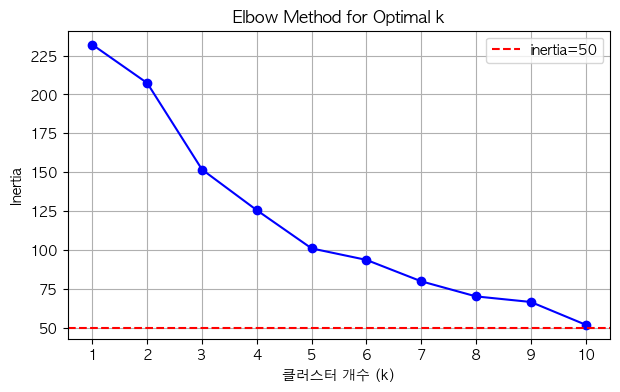

In [100]:
# 2) Elbow method로 적정 클러스터 수 확인 (inertia < 50 기준)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, 'o-', color='blue')
plt.xlabel('클러스터 개수 (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.axhline(50, color='red', linestyle='--', label='inertia=50')
plt.legend()
plt.show()

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_33440/1771913027.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


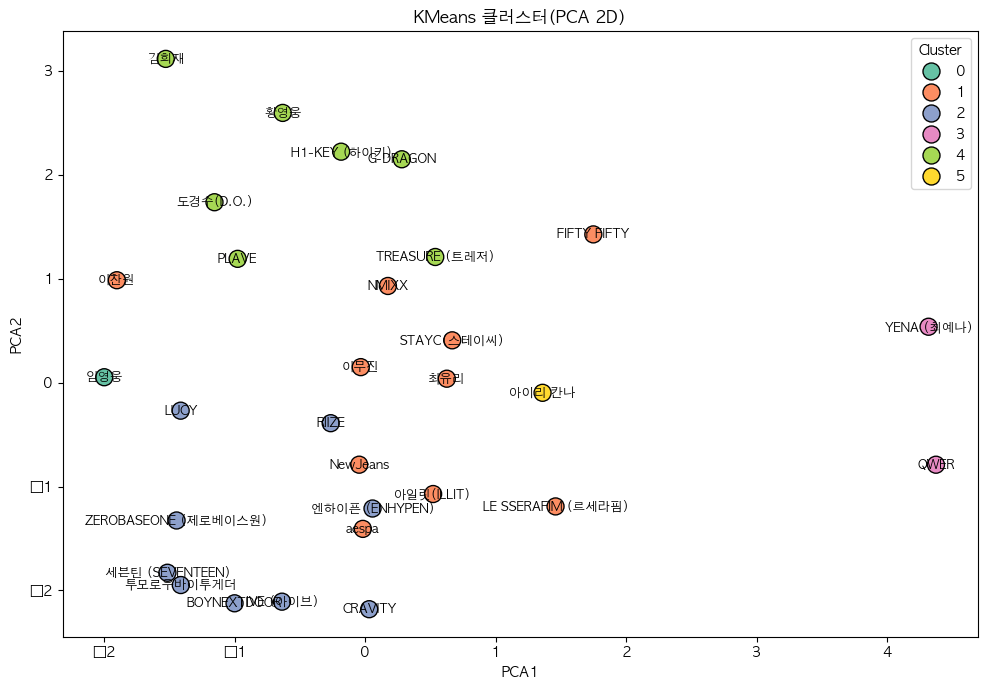

In [101]:
# 3) KMeans 클러스터링
kmeans = KMeans(n_clusters=6, random_state=42) # 클러스터 수는 Elbow method 결과를 참고하여 결정(7개))
clusters = kmeans.fit_predict(X_pca)
fandom_artist_cluster_df['cluster'] = clusters

# 4) 시각화 (PCA 2D scatter plot)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=clusters, palette='Set2', s=150, edgecolor='black'
)
for i, row in fandom_artist_cluster_df.iterrows():
    plt.text(X_pca[i, 0], X_pca[i, 1], row['artist_name'], fontsize=9, ha='center', va='center')
plt.title('KMeans 클러스터(PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_33440/867462800.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


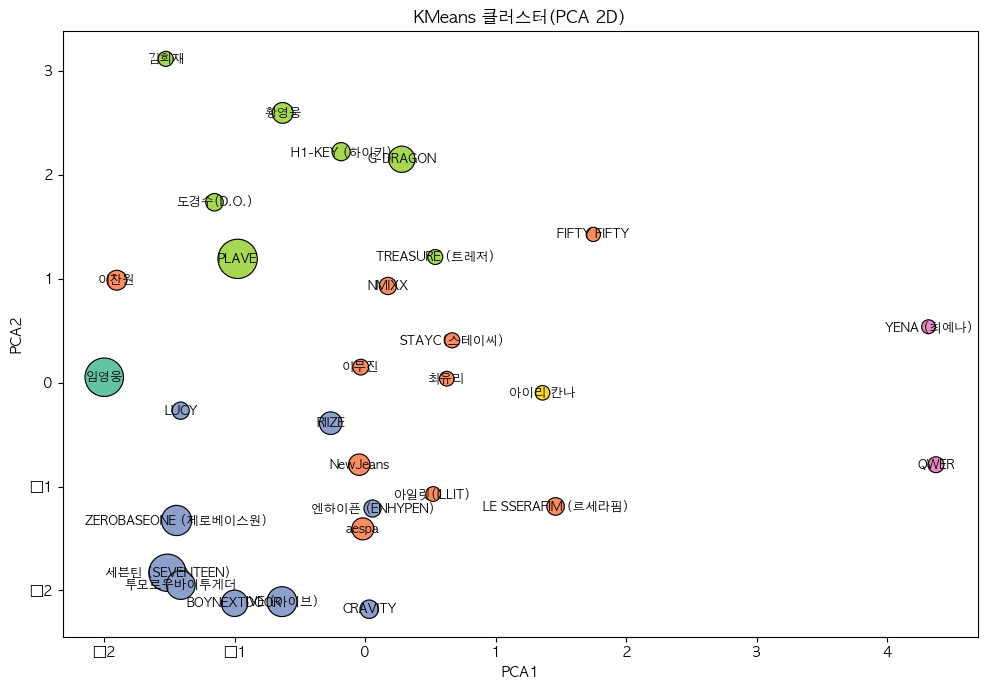

In [102]:
# ...existing code...
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=clusters,
    size=fandom_artist_cluster_df['fandom_user_cnt'],
    sizes=(100, 800),  # 점 크기 범위 (원하는 대로 조정)
    palette='Set2',
    edgecolor='black',
    legend=False  # 레전드 제거
)
for i, row in fandom_artist_cluster_df.iterrows():
    plt.text(X_pca[i, 0], X_pca[i, 1], row['artist_name'], fontsize=9, ha='center', va='center')
plt.title('KMeans 클러스터(PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()
# ...existing code...

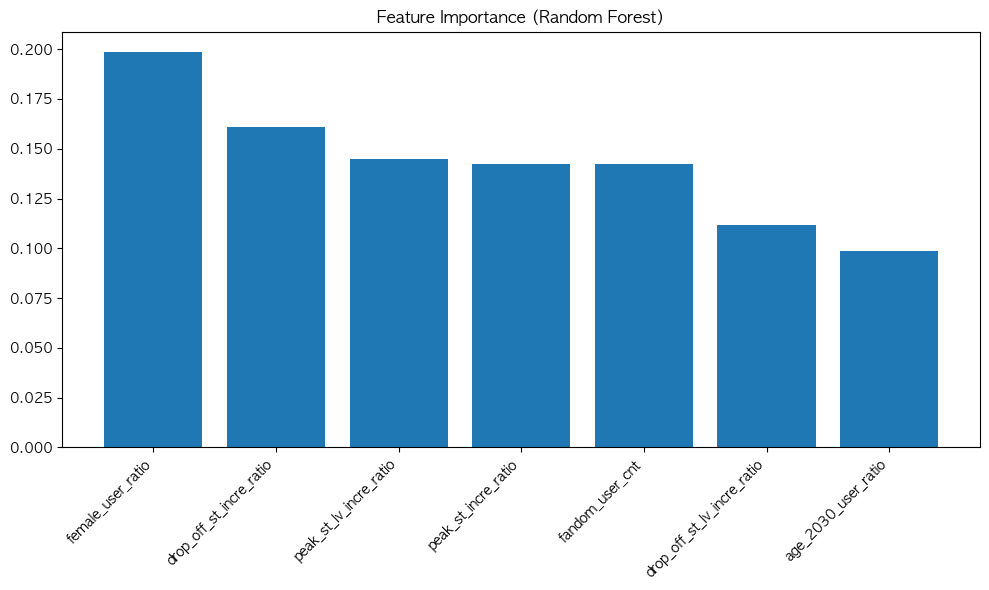

상위 중요 feature: ['female_user_ratio', 'drop_off_st_incre_ratio', 'peak_st_lv_incre_ratio', 'peak_st_incre_ratio', 'fandom_user_cnt', 'drop_off_st_lv_incre_ratio', 'age_2030_user_ratio']


In [103]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 클러스터링 결과를 target(라벨)로 사용
#features = [
#    'fandom_user_cnt', 'male_user_cnt', 'female_user_cnt', 'female_user_ratio',
#    'age_2030_user_cnt', 'age_2030_user_ratio', 'pre_st_cnt', 'peak_st_cnt', 'drop_off_st_cnt',
#    'peak_st_incre', 'peak_st_incre_ratio', 'drop_off_st_incre', 'drop_off_st_incre_ratio',
#    'pre_st_lv', 'peak_st_lv', 'drop_off_st_lv',
#    'peak_st_lv_incre', 'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre', 'drop_off_st_lv_incre_ratio'
#]
features = [
    'fandom_user_cnt',  'female_user_ratio','age_2030_user_ratio',
    'peak_st_incre_ratio', 'drop_off_st_incre_ratio',
    'peak_st_lv_incre_ratio', 'drop_off_st_lv_incre_ratio'
]
X = fandom_artist_cluster_df[features].dropna()
y = fandom_artist_cluster_df.loc[X.index, 'cluster']

# 표준화(선택)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 랜덤포레스트 분류기 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# 중요도 추출
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 중요도 상위 n개 feature 확인
top_n = 8
top_features = [features[i] for i in indices[:top_n]]
print("상위 중요 feature:", top_features)

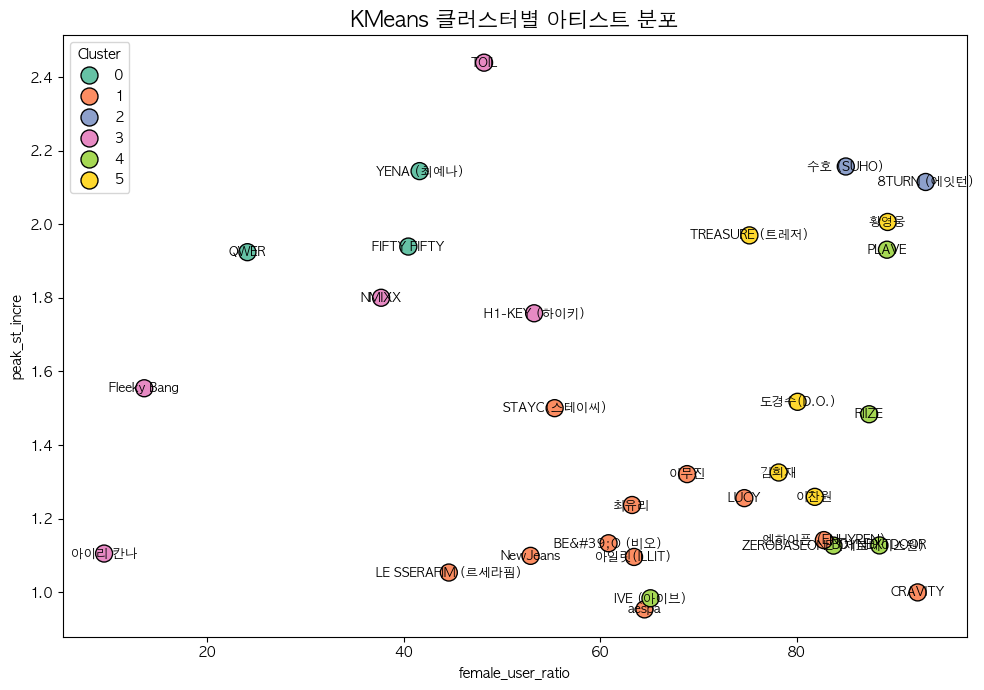

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2차원 feature space 예시: peak_st_incre_ratio vs female_user_ratio
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=fandom_artist_cluster_df,
    x='female_user_ratio',
    y='peak_st_incre',
    hue='cluster',
    palette='Set2',
    s=150,
    edgecolor='black'
)

# 각 점에 아티스트 이름 표시
for i, row in fandom_artist_cluster_df.iterrows():
    plt.text(
        row['female_user_ratio'],
        row['peak_st_incre'],
        row['artist_name'],
        fontsize=9,
        ha='center',
        va='center'
    )

plt.title('KMeans 클러스터별 아티스트 분포', fontsize=15)
plt.xlabel('female_user_ratio')
plt.ylabel('peak_st_incre')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

[클러스터 0] (1명):
임영웅
------------------------------------------------------------
[클러스터 1] (10명):
FIFTY FIFTY, NMIXX, 아일릿(ILLIT), 이찬원, LE SSERAFIM (르세라핌), 최유리, aespa, 이무진, STAYC(스테이씨), NewJeans
------------------------------------------------------------
[클러스터 2] (9명):
ZEROBASEONE (제로베이스원), 세븐틴 (SEVENTEEN), LUCY, 투모로우바이투게더, 엔하이픈 (ENHYPEN), BOYNEXTDOOR, CRAVITY, IVE (아이브), RIIZE
------------------------------------------------------------
[클러스터 3] (2명):
YENA (최예나), QWER
------------------------------------------------------------
[클러스터 4] (7명):
G-DRAGON, 황영웅, TREASURE (트레저), 도경수(D.O.), 김희재, H1-KEY (하이키), PLAVE
------------------------------------------------------------
[클러스터 5] (1명):
아이리 칸나
------------------------------------------------------------


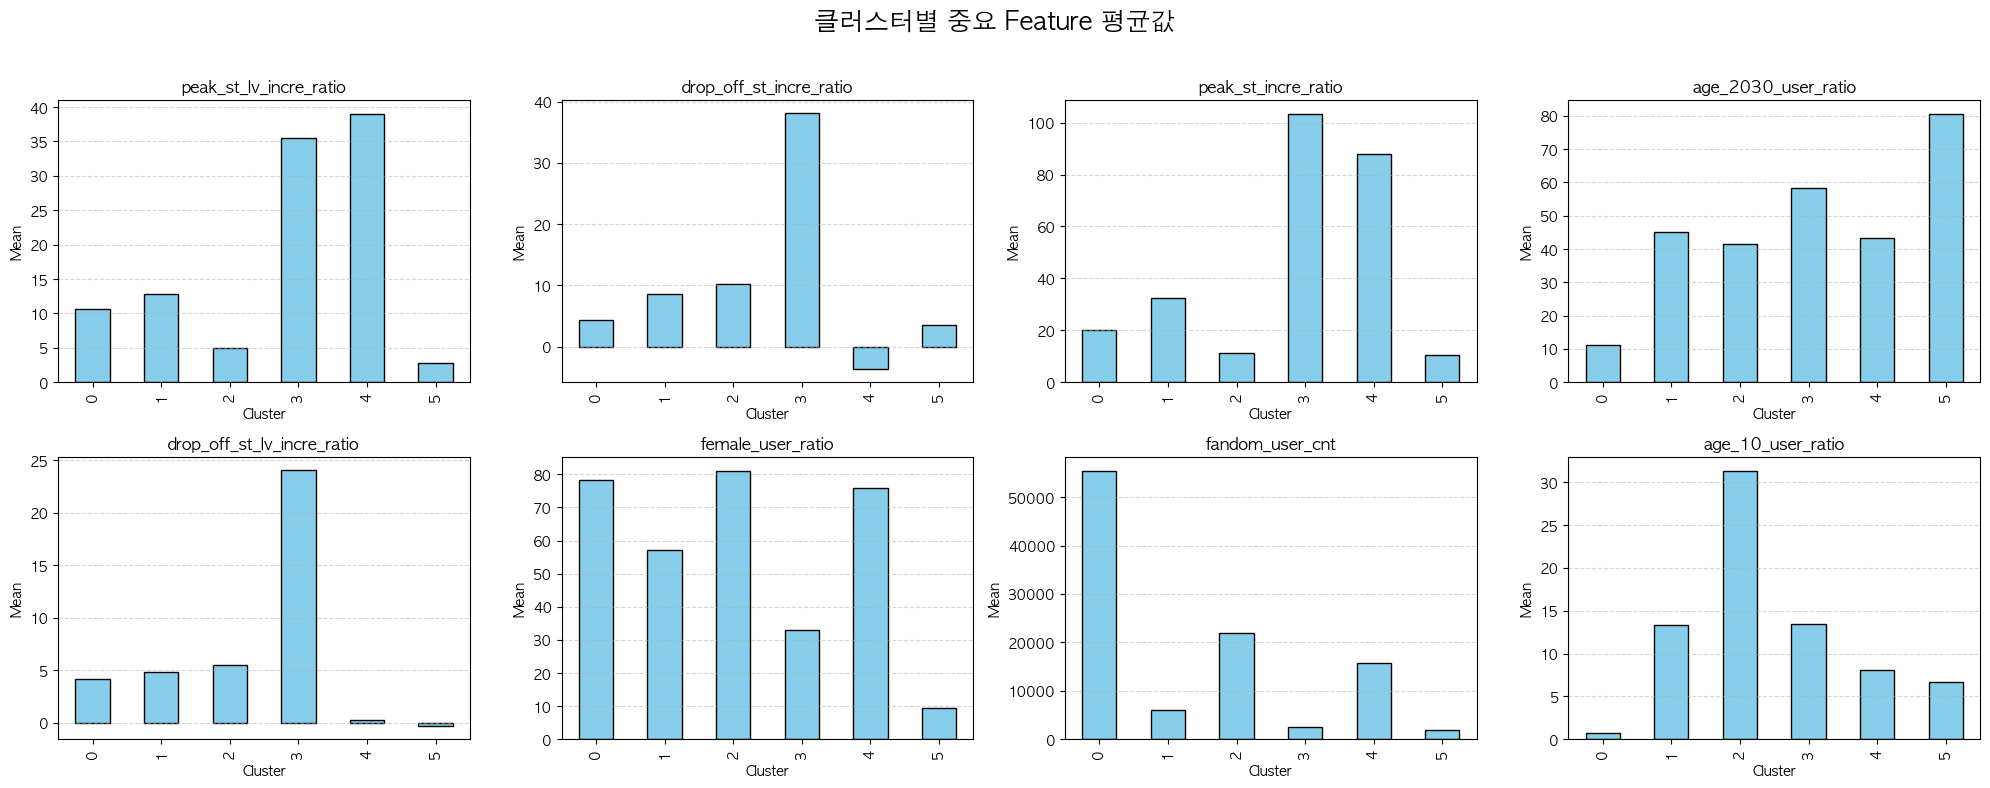

,peak_st_lv_incre_ratio,drop_off_st_incre_ratio,peak_st_incre_ratio,age_2030_user_ratio,drop_off_st_lv_incre_ratio,female_user_ratio,fandom_user_cnt,age_10_user_ratio
cluster,,,,,,,,
0,10.65,4.30,19.96,11.31,4.14,78.35,55459.00,0.78
1,12.76,8.64,32.61,45.13,4.82,57.29,5944.30,13.34
2,5.00,10.21,11.42,41.57,5.53,81.09,21921.89,31.36
3,35.54,38.14,103.43,58.36,24.05,32.84,2482.00,13.48
4,39.03,-3.73,87.93,43.36,0.28,75.73,15684.57,8.07
5,2.79,3.50,10.53,80.64,-0.36,9.48,1983.00,6.66


In [104]:
import matplotlib.pyplot as plt

# 클러스터별 아티스트 리스트 출력
for cluster_num in sorted(fandom_artist_cluster_df['cluster'].unique()):
    artist_list = fandom_artist_cluster_df.loc[fandom_artist_cluster_df['cluster'] == cluster_num, 'artist_name'].tolist()
    print(f"[클러스터 {cluster_num}] ({len(artist_list)}명):")
    print(", ".join(artist_list))
    print("-" * 60)
    
# 상위 중요 feature 리스트
top_features = ['peak_st_lv_incre_ratio', 'drop_off_st_incre_ratio', 'peak_st_incre_ratio', 'age_2030_user_ratio', 'drop_off_st_lv_incre_ratio', 'female_user_ratio', 'fandom_user_cnt','age_10_user_ratio']

# 클러스터별 중요 feature 평균값 계산
cluster_means = fandom_artist_cluster_df.groupby('cluster')[top_features].mean()

# bar plot 그리기
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    ax = axes[i]
    cluster_means[feature].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('클러스터별 중요 Feature 평균값', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# 주요 feature 리스트
top_features = ['peak_st_lv_incre_ratio', 'drop_off_st_incre_ratio', 'peak_st_incre_ratio', 'age_2030_user_ratio', 'drop_off_st_lv_incre_ratio', 'female_user_ratio', 'fandom_user_cnt','age_10_user_ratio']

# 클러스터별 주요 feature 평균값 계산
cluster_summary = fandom_artist_cluster_df.groupby('cluster')[top_features].mean().round(2)
display(cluster_summary)    